In [1]:
import os
import math
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

from src.experiment import train_federated
from src.pipelines import dataset_constant_deviation

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

In [2]:
num_devices = 100
dims = 400
frac_outlying = 0.1
subspace_frac = 0.1
T_start = 1
T = 10
n = 4

In [3]:
num_data = n*(T+T_start)
drift_start = int(num_data*0.5)
drift_end = int(num_data*0.6)
# one device only contains outliers
data, is_outlier = dataset_constant_deviation(num_devices, num_data, dims,
                                              drift_start=0, 
                                              drift_end=num_data, 
                                              frac_drifting_devices=frac_outlying, 
                                              subspace_frac=subspace_frac)

In [4]:
# CREATE N FEDERATED MODELS
models = []
compression_factor = 0.5
encoding_dim = int(dims*compression_factor)
for i in range(num_devices):
    input_data = Input(shape=(dims,))
    encoded = Dense(encoding_dim,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2())(input_data)
    decoded = Dense(dims, activation='sigmoid',
                    kernel_regularizer=tf.keras.regularizers.l2(),
                    activity_regularizer=tf.keras.regularizers.l1(10e-5))(encoded)
    autoencoder = Model(input_data, decoded)
    models.append(autoencoder)
models = np.array(models)

In [5]:
# SAME WEIGHT INITIALIZATION FOR ALL MODELS
initial_weights = models[0].get_weights()
[model.set_weights(initial_weights) for model in models]
for model in models:
    model.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
# TRAIN FEDERATED
frac_available = 0.1
client_ids = range(num_devices)
global_epochs = 20
local_epochs = 1
batch_size = 1

# pre train
print("PRE TRAINING")
for t in range(1, T_start+1):
    data_start = data[:, n*(t-1):t*n]
    models = train_federated(models, data_start, local_epochs, batch_size, frac_available)

print("START MONITORING")
predictions = np.array([])
for t in range(1, T+1):
    print("t = {}".format(t))
    new_data = data[:, n*(t+T_start-1):n*(t+T_start)]
    models = train_federated(models, new_data, local_epochs, batch_size, frac_available)
    new_predictions = np.array([model.predict(new_data[i]) for i, model in enumerate(models)])
    predictions = new_predictions if t == 1 else np.concatenate((predictions, new_predictions), axis=1)
    

PRE TRAINING
Train on 10 devices
Train on 4 samples
4/4 [==============================] - 1s 152ms/sample - loss: 5.8190
Train on 4 samples
4/4 [==============================] - 1s 125ms/sample - loss: 5.8193
Train on 4 samples
4/4 [==============================] - 1s 126ms/sample - loss: 5.8202
Train on 4 samples
4/4 [==============================] - 1s 162ms/sample - loss: 5.8195
Train on 4 samples
4/4 [==============================] - 0s 123ms/sample - loss: 5.8196
Train on 4 samples
4/4 [==============================] - 0s 123ms/sample - loss: 5.8194
Train on 4 samples
4/4 [==============================] - 0s 123ms/sample - loss: 5.8202
Train on 4 samples
4/4 [==============================] - 0s 123ms/sample - loss: 5.8203
Train on 4 samples
4/4 [==============================] - 0s 125ms/sample - loss: 5.8210
Train on 4 samples
4/4 [==============================] - 0s 12ms/sample - loss: 5.2243
START MONITORING
t = 1
Train on 10 devices
Train on 4 samples
4/4 [===========

4/4 [==============================] - 1s 135ms/sample - loss: 2.0901
t = 9
Train on 10 devices
Train on 4 samples
4/4 [==============================] - 1s 141ms/sample - loss: 1.8518
Train on 4 samples
4/4 [==============================] - 0s 12ms/sample - loss: 1.8583
Train on 4 samples
4/4 [==============================] - 1s 150ms/sample - loss: 1.8518
Train on 4 samples
4/4 [==============================] - 1s 152ms/sample - loss: 1.8519
Train on 4 samples
4/4 [==============================] - 0s 14ms/sample - loss: 1.8529
Train on 4 samples
4/4 [==============================] - 0s 14ms/sample - loss: 1.8615
Train on 4 samples
4/4 [==============================] - 0s 13ms/sample - loss: 1.8574
Train on 4 samples
4/4 [==============================] - 1s 143ms/sample - loss: 1.8516
Train on 4 samples
4/4 [==============================] - 1s 137ms/sample - loss: 1.8527
Train on 4 samples
4/4 [==============================] - 1s 132ms/sample - loss: 1.8520
t = 10
Train on 10

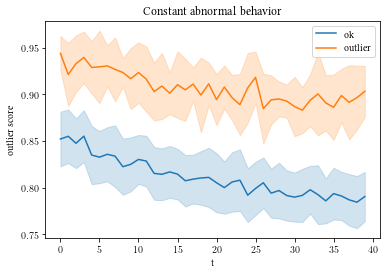

In [7]:
diff = data[:, T_start*n:] - predictions
dist = np.linalg.norm(diff, axis=-1)
dist = dist/np.max(dist)
labels = is_outlier[:, T_start*n:].any(axis=-1)

# ugly but working
io = []
nio = []
for i, row in enumerate(dist):
    for j, val in enumerate(row):
        if labels[i][j]:
            nio.append([j, val])
        else:
            io.append([j, val])
io = pd.DataFrame(io)
nio = pd.DataFrame(nio)

def rolling_mean(d, window=50, axis=0):
    df = pd.DataFrame(d)
    df = df.rolling(window).mean().to_numpy()
    return df.flatten()


sns.lineplot(io[0], io[1], label="ok", ci="sd", err_style="band")
# sns.scatterplot(nio[0], nio[1], label="outlier", color="orange", alpha=0.7)
sns.lineplot(nio[0], nio[1], label="outlier", ci="sd", err_style="band")
plt.xlabel("t")
plt.ylabel("outlier score")
plt.title("Constant abnormal behavior".format(frac_outlying))
plt.legend()
plt.savefig(os.path.join(os.getcwd(), "figures", "constant_abnormal_behavior.pdf"))
plt.show()

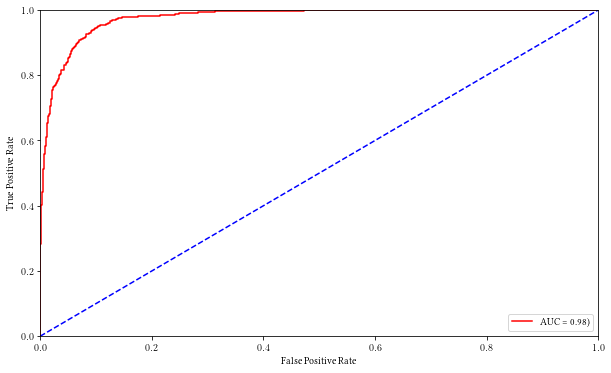

In [8]:
fpr, tpr, thresholds = roc_curve(labels.flatten(), dist.flatten())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='red', label='AUC = %0.2f)' % roc_auc)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000')
plt.legend(loc="lower right")
plt.show()

(400,)


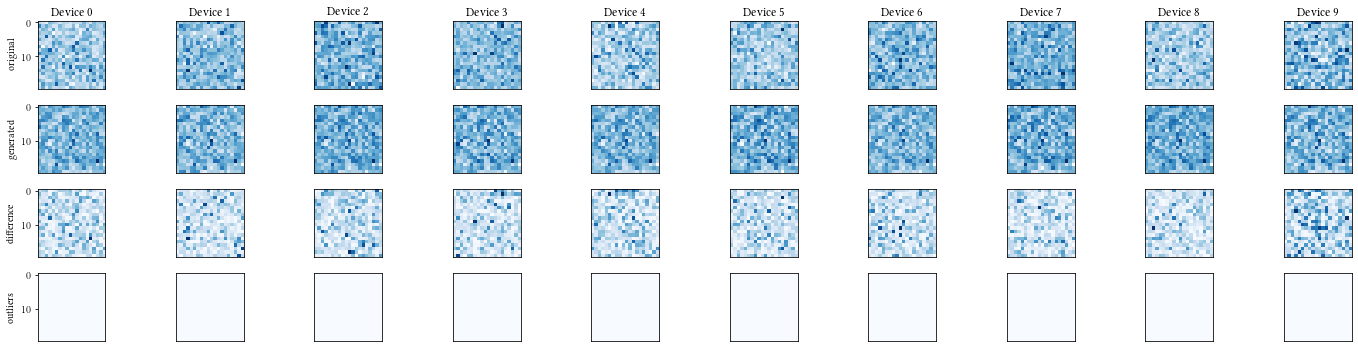

In [9]:
num_plots = 10  # how many digits we will display
fig = plt.figure(figsize=(20, 5))
side_length = int(math.sqrt(dims))
print(predictions[0][0].shape)
for i in range(num_plots):
    example = data[i][-1].reshape(side_length, side_length)
    out = is_outlier[i][0].reshape(side_length, side_length)
    prediction = predictions[i][0].reshape(side_length, side_length)

    # display original
    ax = plt.subplot(4, num_plots, i + 1)
    plt.imshow(example, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    ax.set_title("Device {}".format(i))
    if i == 0:
        ax.set_ylabel("original")
    else:
        ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, num_plots, i + 1 + num_plots)
    plt.imshow(prediction, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("generated")
    else:
        ax.get_yaxis().set_visible(False)

    # display reconstruction
    diff = np.abs(example - prediction)
    ax = plt.subplot(4, num_plots, i + 1 + 2 * num_plots)
    plt.imshow(diff, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("difference")
    else:
        ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, num_plots, i + 1 + 3 * num_plots)
    plt.imshow(np.abs(out), cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("outliers")
    else:
        ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()